In [1]:
# ML-topography Notebook - IOL Calculation for FacoDMEK Eyes
# FIXED VERSION: Proper train/validation/test splits

# %% Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from scipy.optimize import minimize, differential_evolution
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(1)

print("Libraries imported successfully!")
print("\n" + "="*60)
print("IMPORTANT: This version implements proper train/test splitting")
print("to avoid overfitting and provide realistic performance estimates")
print("="*60)

Libraries imported successfully!

IMPORTANT: This version implements proper train/test splitting
to avoid overfitting and provide realistic performance estimates


In [2]:
# %% Cell 2: Load and Explore Data
# Load the Excel file
df = pd.read_excel('FacoDMEK.xlsx', sheet_name='Cleaned Data')

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (97, 29)

Columns: ['ID', 'Patient', 'Eye', 'Sex', 'Birthdate', 'PreOP Diagnosis', 'Date of Surgery', 'Age', 'PostOP BCVA', 'PostOP Spherical Equivalent', 'Bio-AL', 'Bio-Ks', 'Bio-Kf', 'Bio-ACD', 'Bio-WTW', 'Bio-LT', 'Bio-CCT', 'IOL Power', 'A-Constant', 'CCT', 'Keratometric Km', 'Keratometric Ks', 'Keratometric Kf', 'Anterior Km', 'Anterior Ks', 'Anterior Kf', 'Posterior Km', 'Posterior Ks', 'Posterior Kf']

First few rows:


,ID,Patient,Eye,Sex,Birthdate,PreOP Diagnosis,Date of Surgery,Age,PostOP BCVA,PostOP Spherical Equivalent,...,CCT,Keratometric Km,Keratometric Ks,Keratometric Kf,Anterior Km,Anterior Ks,Anterior Kf,Posterior Km,Posterior Ks,Posterior Kf
0,1,facchin stefano,OS,M,1954-06-01,Fuchs,2021-12-01,67,1,-1.250,...,594,45.70,46.5,44.9,50.9,51.8,50.0,-6.45,-6.7,-6.2
1,2,alberghina andrea,OD,M,1967-06-01,Fuchs,2021-02-03,53,0.6,-3.125,...,699,47.20,48.0,46.4,52.6,53.5,51.7,-6.60,-6.8,-6.4
2,3,ardini adriana,OS,F,1951-06-01,Fuchs,2020-06-24,69,0.9,0.500,...,663,40.70,40.9,40.5,45.3,45.5,45.1,-6.60,-6.9,-6.3
3,4,Attaccalite vincenzo,OS,M,1947-06-01,Fuchs,2021-09-29,74,0.9,-0.750,...,526,43.25,43.5,43.0,48.2,48.5,47.9,-5.60,-5.7,-5.5
4,5,bisi anna maria,OD,F,1941-06-01,Fuchs,2020-10-28,79,0.8,-0.250,...,603,43.70,44.6,42.8,48.7,49.7,47.7,-5.80,-5.9,-5.7


In [3]:
# %% Cell 3: Data Preprocessing and Train/Test Split
# Calculate average keratometry from KERATOMETRY (not biometry)
df['K_avg_Kerato'] = (df['Keratometric Ks'] + df['Keratometric Kf']) / 2

# Feature engineering for keratometry-based analysis
df['K_Astigmatism_Kerato'] = df['Keratometric Ks'] - df['Keratometric Kf']
df['Post_Ant_Ratio'] = df['Posterior Km'] / df['Anterior Km']
df['AL_K_Ratio'] = df['Bio-AL'] / df['K_avg_Kerato']

# Display summary statistics
print("Summary of key variables:")
print(df[['Bio-AL', 'K_avg_Kerato', 'IOL Power', 'PostOP Spherical Equivalent', 
          'CCT', 'Posterior Km']].describe())

# Check for missing values
print("\nMissing values in key columns:")
missing_counts = df[['Bio-AL', 'K_avg_Kerato', 'IOL Power', 
                     'PostOP Spherical Equivalent', 'CCT', 
                     'A-Constant', 'Posterior Km']].isnull().sum()
print(missing_counts)

# CRITICAL: Remove incomplete cases BEFORE splitting
required_cols = ['Bio-AL', 'K_avg_Kerato', 'IOL Power', 
                 'PostOP Spherical Equivalent', 'A-Constant']
df_complete = df[df[required_cols].notna().all(axis=1)].copy()

print(f"\nComplete cases for analysis: {len(df_complete)} out of {len(df)}")

# PROPER TRAIN/TEST SPLIT - DO THIS BEFORE ANY ANALYSIS
print("\n" + "="*60)
print("CREATING TRAIN/TEST SPLIT")
print("="*60)

# Create stratification bins based on outcome to ensure balanced split
df_complete['SE_bins'] = pd.qcut(df_complete['PostOP Spherical Equivalent'], 
                                  q=5, labels=False, duplicates='drop')

# Split data: 80% train/validation, 20% test
df_train_val, df_test = train_test_split(
    df_complete, 
    test_size=0.2, 
    random_state=42,
    stratify=df_complete['SE_bins']
)

# Remove the temporary stratification column
df_train_val = df_train_val.drop('SE_bins', axis=1)
df_test = df_test.drop('SE_bins', axis=1)
df_complete = df_complete.drop('SE_bins', axis=1)

print(f"Train/Validation set: {len(df_train_val)} eyes (80%)")
print(f"Test set: {len(df_test)} eyes (20%) - HELD OUT UNTIL FINAL EVALUATION")
print("\nTest set will NOT be used until the very end!")

# Save test indices for later reference
test_indices = df_test.index.tolist()

Summary of key variables:
          Bio-AL  K_avg_Kerato  IOL Power  PostOP Spherical Equivalent  \
count  97.000000     97.000000  97.000000                    97.000000   
mean   23.831753     43.596907  21.463918                    -0.159794   
std     1.375736      1.876164   4.117574                     1.347348   
min    21.170000     39.050000  11.000000                    -3.875000   
25%    22.930000     42.400000  19.000000                    -1.000000   
50%    23.640000     43.700000  22.000000                     0.000000   
75%    24.590000     45.000000  24.000000                     0.500000   
max    28.230000     47.350000  30.000000                     5.000000   

              CCT  Posterior Km  
count   97.000000     97.000000  
mean   620.567010     -5.821134  
std     79.396278      0.386277  
min    448.000000     -6.700000  
25%    568.000000     -6.050000  
50%    606.000000     -5.750000  
75%    657.000000     -5.600000  
max    880.000000     -5.100000  



In [4]:
# %% Cell 4: Implement SRK/T Formula with Keratometry K Values
def calculate_SRKT(AL, K, A_const, nc=1.333):
    """
    Calculate IOL power using SRK/T formula
    Uses keratometry K values
    Returns NaN if inputs are invalid
    """
    # Check for valid inputs
    if pd.isna(AL) or pd.isna(K) or pd.isna(A_const) or K <= 0 or AL <= 0:
        return np.nan
    
    try:
        # Constants
        na = 1.336
        V = 12
        
        # Corneal radius from keratometry K
        r = 337.5 / K
        
        # Axial length correction
        if AL > 24.2:
            LCOR = -3.446 + 1.716 * AL - 0.0237 * AL**2
        else:
            LCOR = AL
        
        # Corneal width
        Cw = -5.41 + 0.58412 * LCOR + 0.098 * K
        
        # Check if we can calculate H (avoid negative square root)
        if r**2 - (Cw**2 / 4) < 0:
            return np.nan
        
        # Corneal height
        H = r - np.sqrt(r**2 - (Cw**2 / 4))
        
        # ACD constant from A-constant
        ACDconst = 0.62467 * A_const - 68.747
        
        # Offset
        offset = ACDconst - 3.336
        
        # Estimated postoperative ACD
        ACDest = H + offset
        
        # Retinal thickness correction
        RETHICK = 0.65696 - 0.02029 * AL
        LOPT = AL + RETHICK
        
        # Calculate IOL power for emmetropia
        ncm1 = nc - 1
        IOL = (1000 * na * (na * r - ncm1 * LOPT)) / ((LOPT - ACDest) * (na * r - ncm1 * ACDest))
        
        return IOL
    except:
        return np.nan

# Calculate SRK/T predictions ON TRAINING DATA ONLY
print("Calculating baseline SRK/T performance on TRAINING data...")

df_train_val['SRKT_Prediction'] = df_train_val.apply(
    lambda row: calculate_SRKT(row['Bio-AL'], row['K_avg_Kerato'], row['A-Constant']), 
    axis=1
)

# Calculate expected spherical equivalent based on surgeon's choice
df_train_val['Expected_SE'] = -(df_train_val['IOL Power'] - df_train_val['SRKT_Prediction'])
df_train_val['SRKT_Error'] = df_train_val['PostOP Spherical Equivalent'] - df_train_val['Expected_SE']

# Remove rows with NaN errors for analysis
valid_train = df_train_val['SRKT_Error'].notna()

print("\nBaseline SRK/T Performance (Training Data):")
print(f"Valid predictions: {valid_train.sum()} out of {len(df_train_val)}")
if valid_train.sum() > 0:
    print(f"Mean Error: {df_train_val.loc[valid_train, 'SRKT_Error'].mean():.3f} D")
    print(f"Mean Absolute Error: {df_train_val.loc[valid_train, 'SRKT_Error'].abs().mean():.3f} D")
    print(f"Standard Deviation: {df_train_val.loc[valid_train, 'SRKT_Error'].std():.3f} D")

print("\n" + "="*60)
print("NOTE: Test set is NOT touched - preserving it for final evaluation")
print("="*60)

Calculating baseline SRK/T performance on TRAINING data...

Baseline SRK/T Performance (Training Data):
Valid predictions: 77 out of 77
Mean Error: 1.081 D
Mean Absolute Error: 1.636 D
Standard Deviation: 2.204 D

NOTE: Test set is NOT touched - preserving it for final evaluation


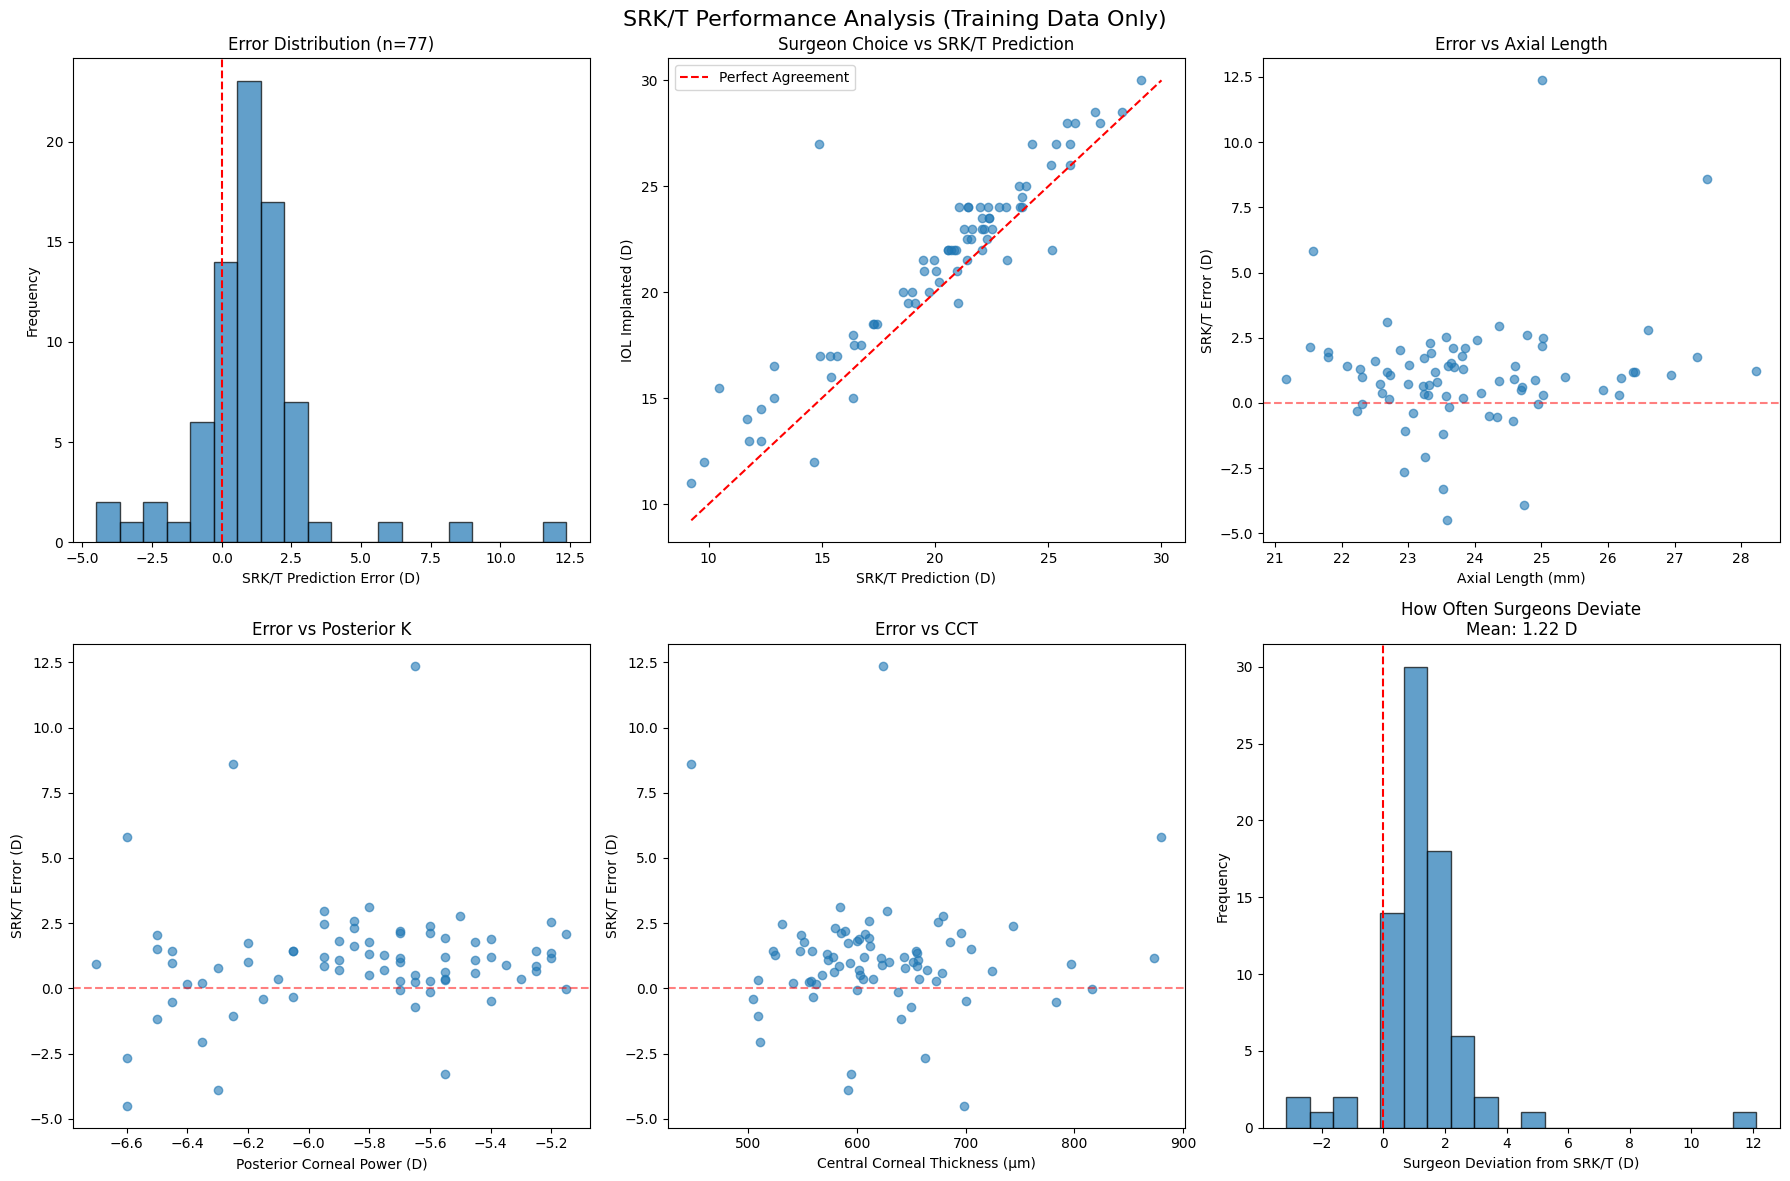


Percentage of eyes within target (Training Data):
±0.25 D: 6.5%
±0.50 D: 18.2%
±1.00 D: 41.6%


In [5]:
# %% Cell 5: Visualize SRK/T Performance (Training Data Only)
# Only use training data for visualization
df_train_valid = df_train_val[df_train_val['SRKT_Error'].notna()].copy()

if len(df_train_valid) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('SRK/T Performance Analysis (Training Data Only)', fontsize=16)

    # Plot 1: Error Distribution
    axes[0, 0].hist(df_train_valid['SRKT_Error'], bins=20, alpha=0.7, edgecolor='black')
    axes[0, 0].axvline(x=0, color='red', linestyle='--')
    axes[0, 0].set_xlabel('SRK/T Prediction Error (D)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title(f'Error Distribution (n={len(df_train_valid)})')

    # Plot 2: Surgeon's Choice vs SRK/T Prediction
    axes[0, 1].scatter(df_train_valid['SRKT_Prediction'], df_train_valid['IOL Power'], alpha=0.6)
    min_val = min(df_train_valid['SRKT_Prediction'].min(), df_train_valid['IOL Power'].min())
    max_val = max(df_train_valid['SRKT_Prediction'].max(), df_train_valid['IOL Power'].max())
    axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Agreement')
    axes[0, 1].set_xlabel('SRK/T Prediction (D)')
    axes[0, 1].set_ylabel('IOL Implanted (D)')
    axes[0, 1].set_title('Surgeon Choice vs SRK/T Prediction')
    axes[0, 1].legend()

    # Plot 3: Error vs Axial Length
    axes[0, 2].scatter(df_train_valid['Bio-AL'], df_train_valid['SRKT_Error'], alpha=0.6)
    axes[0, 2].set_xlabel('Axial Length (mm)')
    axes[0, 2].set_ylabel('SRK/T Error (D)')
    axes[0, 2].set_title('Error vs Axial Length')
    axes[0, 2].axhline(y=0, color='red', linestyle='--', alpha=0.5)

    # Plot 4: Error vs Posterior Corneal Power
    axes[1, 0].scatter(df_train_valid['Posterior Km'], df_train_valid['SRKT_Error'], alpha=0.6)
    axes[1, 0].set_xlabel('Posterior Corneal Power (D)')
    axes[1, 0].set_ylabel('SRK/T Error (D)')
    axes[1, 0].set_title('Error vs Posterior K')
    axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

    # Plot 5: Error vs CCT
    valid_cct = df_train_valid[df_train_valid['CCT'].notna()]
    axes[1, 1].scatter(valid_cct['CCT'], valid_cct['SRKT_Error'], alpha=0.6)
    axes[1, 1].set_xlabel('Central Corneal Thickness (μm)')
    axes[1, 1].set_ylabel('SRK/T Error (D)')
    axes[1, 1].set_title('Error vs CCT')
    axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

    # Plot 6: Surgeon Deviation Distribution
    surgeon_deviation = df_train_valid['IOL Power'] - df_train_valid['SRKT_Prediction']
    axes[1, 2].hist(surgeon_deviation, bins=20, edgecolor='black', alpha=0.7)
    axes[1, 2].axvline(x=0, color='red', linestyle='--')
    axes[1, 2].set_xlabel('Surgeon Deviation from SRK/T (D)')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title(f'How Often Surgeons Deviate\nMean: {surgeon_deviation.mean():.2f} D')

    plt.tight_layout()
    plt.show()

    # Calculate percentage within target ranges (training data)
    within_025 = (df_train_valid['SRKT_Error'].abs() <= 0.25).sum() / len(df_train_valid) * 100
    within_050 = (df_train_valid['SRKT_Error'].abs() <= 0.50).sum() / len(df_train_valid) * 100
    within_100 = (df_train_valid['SRKT_Error'].abs() <= 1.00).sum() / len(df_train_valid) * 100
    
    print(f"\nPercentage of eyes within target (Training Data):")
    print(f"±0.25 D: {within_025:.1f}%")
    print(f"±0.50 D: {within_050:.1f}%")
    print(f"±1.00 D: {within_100:.1f}%")
else:
    print("No valid cases for visualization")

MACHINE LEARNING OPTIMIZATION OF CORNEAL REFRACTIVE INDEX
Using ONLY training data for optimization
Cross-validation within training set to avoid overfitting

Performing Grid Search with 5-Fold Cross-Validation...
nc = 1.3300: MAE = 1.3643 (±0.1749)
nc = 1.3305: MAE = 1.3953 (±0.1813)
nc = 1.3310: MAE = 1.4298 (±0.1893)
nc = 1.3315: MAE = 1.4704 (±0.1958)
nc = 1.3320: MAE = 1.5201 (±0.2009)
nc = 1.3325: MAE = 1.5754 (±0.2016)
nc = 1.3330: MAE = 1.6328 (±0.2008)
nc = 1.3335: MAE = 1.6927 (±0.1999)
nc = 1.3340: MAE = 1.7569 (±0.2026)
nc = 1.3345: MAE = 1.8222 (±0.2079)
nc = 1.3350: MAE = 1.8897 (±0.2140)
nc = 1.3355: MAE = 1.9602 (±0.2190)
nc = 1.3360: MAE = 2.0323 (±0.2252)
nc = 1.3365: MAE = 2.1072 (±0.2350)
nc = 1.3370: MAE = 2.1826 (±0.2457)
nc = 1.3375: MAE = 2.2588 (±0.2567)
nc = 1.3380: MAE = 2.3377 (±0.2674)
nc = 1.3385: MAE = 2.4206 (±0.2741)
nc = 1.3390: MAE = 2.5043 (±0.2798)
nc = 1.3395: MAE = 2.5880 (±0.2859)
nc = 1.3400: MAE = 2.6718 (±0.2923)

Best corneal refractive index

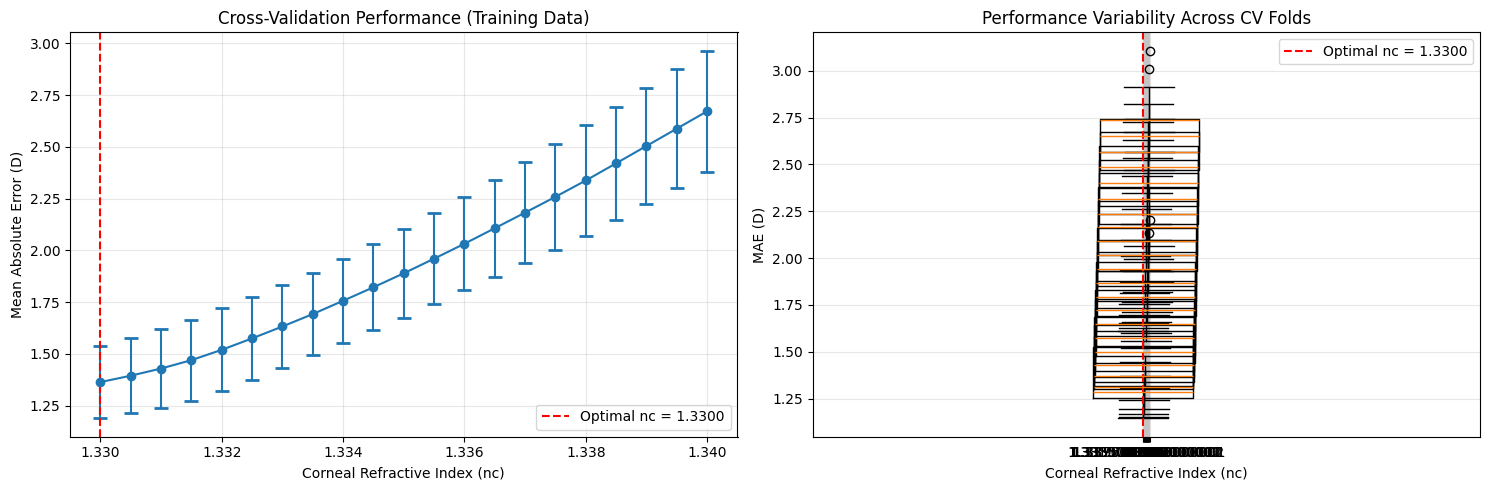


Optimal nc saved: 1.3300

NOTE: We have NOT touched the test set yet!


In [6]:
# %% Cell 6: ML-Based Optimization of Corneal Refractive Index
print("MACHINE LEARNING OPTIMIZATION OF CORNEAL REFRACTIVE INDEX")
print("="*60)
print("Using ONLY training data for optimization")
print("Cross-validation within training set to avoid overfitting")
print("="*60)

# Prepare training data for ML
df_ml_train = df_train_val[df_train_val['SRKT_Error'].notna()].copy()

# Custom scoring function for cross-validation
def evaluate_nc_cv(nc_value, X_train, X_val, df_train, df_val):
    """
    Evaluate nc on validation set
    """
    # Calculate predictions for validation set
    predictions = []
    for idx, row in X_val.iterrows():
        pred = calculate_SRKT(row['Bio-AL'], row['K_avg_Kerato'], 
                            row['A-Constant'], nc=nc_value)
        predictions.append(pred)
    
    predictions = np.array(predictions)
    
    # Get actual IOL powers and SE for validation set
    actual_iol = df_val['IOL Power'].values
    actual_se = df_val['PostOP Spherical Equivalent'].values
    
    # Calculate expected SE based on surgeon's choice
    expected_se = -(actual_iol - predictions)
    
    # Calculate errors
    errors = actual_se - expected_se
    
    # Remove NaN values
    valid_mask = ~np.isnan(errors)
    if valid_mask.sum() == 0:
        return np.inf
    
    return np.mean(np.abs(errors[valid_mask]))

# Grid search with proper cross-validation ON TRAINING DATA ONLY
print("\nPerforming Grid Search with 5-Fold Cross-Validation...")

# Create parameter grid
nc_values = np.linspace(1.330, 1.340, 21)
cv_results = []

# Setup cross-validation (using training data only)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# For each nc value
for nc in nc_values:
    fold_scores = []
    
    # Perform cross-validation on training data
    for fold, (train_idx, val_idx) in enumerate(kf.split(df_ml_train)):
        # Split training data into train/val folds
        df_fold_train = df_ml_train.iloc[train_idx]
        df_fold_val = df_ml_train.iloc[val_idx]
        
        X_fold_train = df_fold_train[['Bio-AL', 'K_avg_Kerato', 'A-Constant']]
        X_fold_val = df_fold_val[['Bio-AL', 'K_avg_Kerato', 'A-Constant']]
        
        # Evaluate on validation fold
        mae = evaluate_nc_cv(nc, X_fold_train, X_fold_val, df_fold_train, df_fold_val)
        fold_scores.append(mae)
    
    # Store results
    cv_results.append({
        'nc': nc,
        'mean_mae': np.mean(fold_scores),
        'std_mae': np.std(fold_scores),
        'fold_scores': fold_scores
    })
    
    print(f"nc = {nc:.4f}: MAE = {np.mean(fold_scores):.4f} (±{np.std(fold_scores):.4f})")

# Convert to DataFrame
cv_results_df = pd.DataFrame(cv_results)

# Find best nc
best_idx = cv_results_df['mean_mae'].idxmin()
best_nc = cv_results_df.loc[best_idx, 'nc']
best_cv_mae = cv_results_df.loc[best_idx, 'mean_mae']
best_cv_std = cv_results_df.loc[best_idx, 'std_mae']

print(f"\nBest corneal refractive index (nc): {best_nc:.4f}")
print(f"Cross-validation MAE: {best_cv_mae:.3f} ± {best_cv_std:.3f} D")

# Visualize optimization landscape
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: MAE vs nc with error bars
ax1.errorbar(cv_results_df['nc'], cv_results_df['mean_mae'], 
             yerr=cv_results_df['std_mae'], fmt='o-', capsize=5, capthick=2)
ax1.axvline(x=best_nc, color='red', linestyle='--', 
            label=f'Optimal nc = {best_nc:.4f}')
ax1.set_xlabel('Corneal Refractive Index (nc)')
ax1.set_ylabel('Mean Absolute Error (D)')
ax1.set_title('Cross-Validation Performance (Training Data)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Box plot of fold scores for each nc
fold_scores_matrix = np.array([r['fold_scores'] for r in cv_results])
ax2.boxplot(fold_scores_matrix.T, positions=cv_results_df['nc'])
ax2.axvline(x=best_nc, color='red', linestyle='--', 
            label=f'Optimal nc = {best_nc:.4f}')
ax2.set_xlabel('Corneal Refractive Index (nc)')
ax2.set_ylabel('MAE (D)')
ax2.set_title('Performance Variability Across CV Folds')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save optimized nc for use in Cell 7
optimal_nc_ml = best_nc
print(f"\nOptimal nc saved: {optimal_nc_ml:.4f}")
print("\nNOTE: We have NOT touched the test set yet!")

In [7]:
# %% Cell 7: ML-Optimized SRK/T with Ensemble Methods
print("\nMACHINE LEARNING OPTIMIZATION OF SRK/T FORMULA CONSTANTS")
print("="*60)
print("Still using ONLY training data for optimization")
print("="*60)

# Use optimized nc from Cell 6
if 'optimal_nc_ml' not in globals():
    optimal_nc_ml = 1.333

print(f"Using optimized nc from Cell 6: {optimal_nc_ml:.4f}")

# Extended SRK/T with learnable parameters
def calculate_SRKT_ml(AL, K, A_const, params):
    """
    ML-optimized SRK/T formula
    """
    nc = optimal_nc_ml
    
    # Unpack parameters
    cw_const1, cw_const2, cw_const3 = params[0:3]
    acd_const1, acd_const2 = params[3:5]
    offset_const = params[5]
    rethick_const1, rethick_const2 = params[6:8]
    lcor_threshold = params[8]
    
    if pd.isna(AL) or pd.isna(K) or pd.isna(A_const) or K <= 0 or AL <= 0:
        return np.nan
    
    try:
        na = 1.336
        r = 337.5 / K
        
        if AL > lcor_threshold:
            LCOR = -3.446 + 1.716 * AL - 0.0237 * AL**2
        else:
            LCOR = AL
        
        Cw = cw_const1 + cw_const2 * LCOR + cw_const3 * K
        
        if r**2 - (Cw**2 / 4) < 0:
            return np.nan
        
        H = r - np.sqrt(r**2 - (Cw**2 / 4))
        ACDconst = acd_const1 * A_const - acd_const2
        offset = ACDconst - offset_const
        ACDest = H + offset
        
        RETHICK = rethick_const1 - rethick_const2 * AL
        LOPT = AL + RETHICK
        
        ncm1 = nc - 1
        IOL = (1000 * na * (na * r - ncm1 * LOPT)) / ((LOPT - ACDest) * (na * r - ncm1 * ACDest))
        
        return IOL
    except:
        return np.nan

# Prepare training data
df_opt_train = df_train_val[df_train_val['SRKT_Error'].notna()].copy()

# Add engineered features
df_opt_train['K_Astigmatism'] = df_opt_train['Keratometric Ks'] - df_opt_train['Keratometric Kf']
df_opt_train['AL_K_Ratio'] = df_opt_train['Bio-AL'] / df_opt_train['K_avg_Kerato']
df_opt_train['Post_Ant_Ratio'] = df_opt_train['Posterior Km'] / df_opt_train['Anterior Km']

# Feature matrix for ML models
feature_cols = ['Bio-AL', 'K_avg_Kerato', 'A-Constant', 'CCT', 'K_Astigmatism', 
                'Posterior Km', 'Anterior Km', 'Bio-ACD', 'Bio-LT', 'AL_K_Ratio']

# Handle missing values (using training data statistics only)
for col in feature_cols:
    if col in df_opt_train.columns:
        median_val = df_opt_train[col].median()
        df_opt_train[col] = df_opt_train[col].fillna(median_val)
        # Store for later use on test set
        df_opt_train[f'{col}_median'] = median_val

X_features_train = df_opt_train[feature_cols]

# Objective function for optimizing SRK/T constants
def objective_ml_constants(params):
    """Cross-validation based objective function"""
    errors_all = []
    
    # 5-fold cross-validation on training data
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(df_opt_train):
        val_data = df_opt_train.iloc[val_idx]
        
        predictions = val_data.apply(
            lambda row: calculate_SRKT_ml(row['Bio-AL'], row['K_avg_Kerato'], 
                                         row['A-Constant'], params), 
            axis=1
        )
        
        expected_se = -(val_data['IOL Power'] - predictions)
        errors = val_data['PostOP Spherical Equivalent'] - expected_se
        
        valid_errors = errors[errors.notna()]
        if len(valid_errors) > 0:
            errors_all.extend(valid_errors.tolist())
    
    if len(errors_all) == 0:
        return 999
    
    return np.mean(np.abs(errors_all))

# Initial parameters and bounds
initial_params = [-5.41, 0.58412, 0.098, 0.62467, 68.747, 3.336, 0.65696, 0.02029, 24.2]
bounds = [(-6.5, -4.3), (0.47, 0.70), (0.078, 0.118), (0.50, 0.75), 
          (55.0, 82.0), (2.7, 4.0), (0.52, 0.79), (0.016, 0.024), (23.0, 25.5)]

print("\nOptimizing SRK/T formula constants...")

# Run optimization
result = differential_evolution(
    objective_ml_constants, 
    bounds,
    maxiter=20,  # Reduced for faster execution
    popsize=10,
    seed=42,
    disp=True,
    workers=1
)

optimal_params = result.x

print(f"\nOptimization complete!")
print(f"Cross-validation MAE: {result.fun:.3f} D")

# Train ensemble models for residual correction
print("\nTraining Ensemble Models for Residual Correction...")

# Calculate predictions with optimized formula on training data
df_opt_train['SRKT_ML_Optimized'] = df_opt_train.apply(
    lambda row: calculate_SRKT_ml(row['Bio-AL'], row['K_avg_Kerato'], 
                                 row['A-Constant'], optimal_params), 
    axis=1
)

df_opt_train['Expected_SE_ML_Opt'] = -(df_opt_train['IOL Power'] - df_opt_train['SRKT_ML_Optimized'])
df_opt_train['Error_ML_Opt'] = df_opt_train['PostOP Spherical Equivalent'] - df_opt_train['Expected_SE_ML_Opt']

# Prepare data for ensemble
valid_mask = df_opt_train['SRKT_ML_Optimized'].notna()
X_train = X_features_train[valid_mask]
y_residuals = df_opt_train.loc[valid_mask, 'Error_ML_Opt']

# Create pipelines
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=50, max_depth=4, 
                                 min_samples_split=10, random_state=42))
])

gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingRegressor(n_estimators=50, max_depth=3, 
                                     learning_rate=0.05, random_state=42))
])

# Simpler neural network to avoid overfitting
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(hidden_layer_sizes=(20,), max_iter=300, 
                         early_stopping=True, validation_fraction=0.2,
                         random_state=42))
])

# Cross-validation for ensemble models
models = {
    'Random Forest': rf_pipeline,
    'Gradient Boosting': gb_pipeline,
    'Neural Network': mlp_pipeline
}

print("\nEvaluating ensemble models with cross-validation...")
best_model_name = None
best_model_score = np.inf

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_residuals, 
                           cv=5, scoring='neg_mean_absolute_error')
    mean_score = -scores.mean()
    print(f"{name} CV MAE: {mean_score:.3f} (±{scores.std():.3f})")
    
    if mean_score < best_model_score:
        best_model_score = mean_score
        best_model_name = name

# Train best ensemble model on all training data
print(f"\nUsing {best_model_name} for ensemble correction")
best_ensemble = models[best_model_name]
best_ensemble.fit(X_train, y_residuals)

# Store everything we need for test evaluation
ml_model_info = {
    'optimal_nc': optimal_nc_ml,
    'optimal_params': optimal_params,
    'best_ensemble': best_ensemble,
    'feature_cols': feature_cols,
    'feature_medians': {col: df_opt_train[f'{col}_median'].iloc[0] 
                        for col in feature_cols 
                        if f'{col}_median' in df_opt_train.columns}
}

print("\n" + "="*60)
print("Training complete! Ready for final test set evaluation")
print("All models trained ONLY on training data")
print("="*60)


MACHINE LEARNING OPTIMIZATION OF SRK/T FORMULA CONSTANTS
Still using ONLY training data for optimization
Using optimized nc from Cell 6: 1.3300

Optimizing SRK/T formula constants...
differential_evolution step 1: f(x)= 1.3927849609112362
differential_evolution step 2: f(x)= 1.3272355902054185
differential_evolution step 3: f(x)= 1.3272355902054185
differential_evolution step 4: f(x)= 1.3272355902054185
differential_evolution step 5: f(x)= 1.2932907687071797
differential_evolution step 6: f(x)= 1.2932907687071797
differential_evolution step 7: f(x)= 1.2932907687071797
differential_evolution step 8: f(x)= 1.2932907687071797
differential_evolution step 9: f(x)= 1.2794473331495575
differential_evolution step 10: f(x)= 1.279341147794661
differential_evolution step 11: f(x)= 1.279341147794661
differential_evolution step 12: f(x)= 1.279341147794661
differential_evolution step 13: f(x)= 1.279341147794661
differential_evolution step 14: f(x)= 1.279341147794661
differential_evolution step 15: 


################################################################################
#                                                                              #
#                         FINAL TEST SET EVALUATION                            #
#                                                                              #
################################################################################

This is the FIRST and ONLY time we touch the test set!
These results represent unbiased performance estimates.

1. BASELINE SRK/T PERFORMANCE:

2. ML-OPTIMIZED nc PERFORMANCE:

3. ML-OPTIMIZED CONSTANTS PERFORMANCE:

4. ML + ENSEMBLE PERFORMANCE:

FINAL TEST SET RESULTS

Test Set Performance Comparison:
                Method  n   MAE  SD  RMSE  Within ±0.25D  Within ±0.50D  Within ±1.00D
        Baseline SRK/T 20 1.243 0.9 1.497         15.000         20.000         45.000
       ML-Optimized nc 20 1.022 0.7 1.231         20.000         25.000         50.000
ML-Optimized Constants 20  

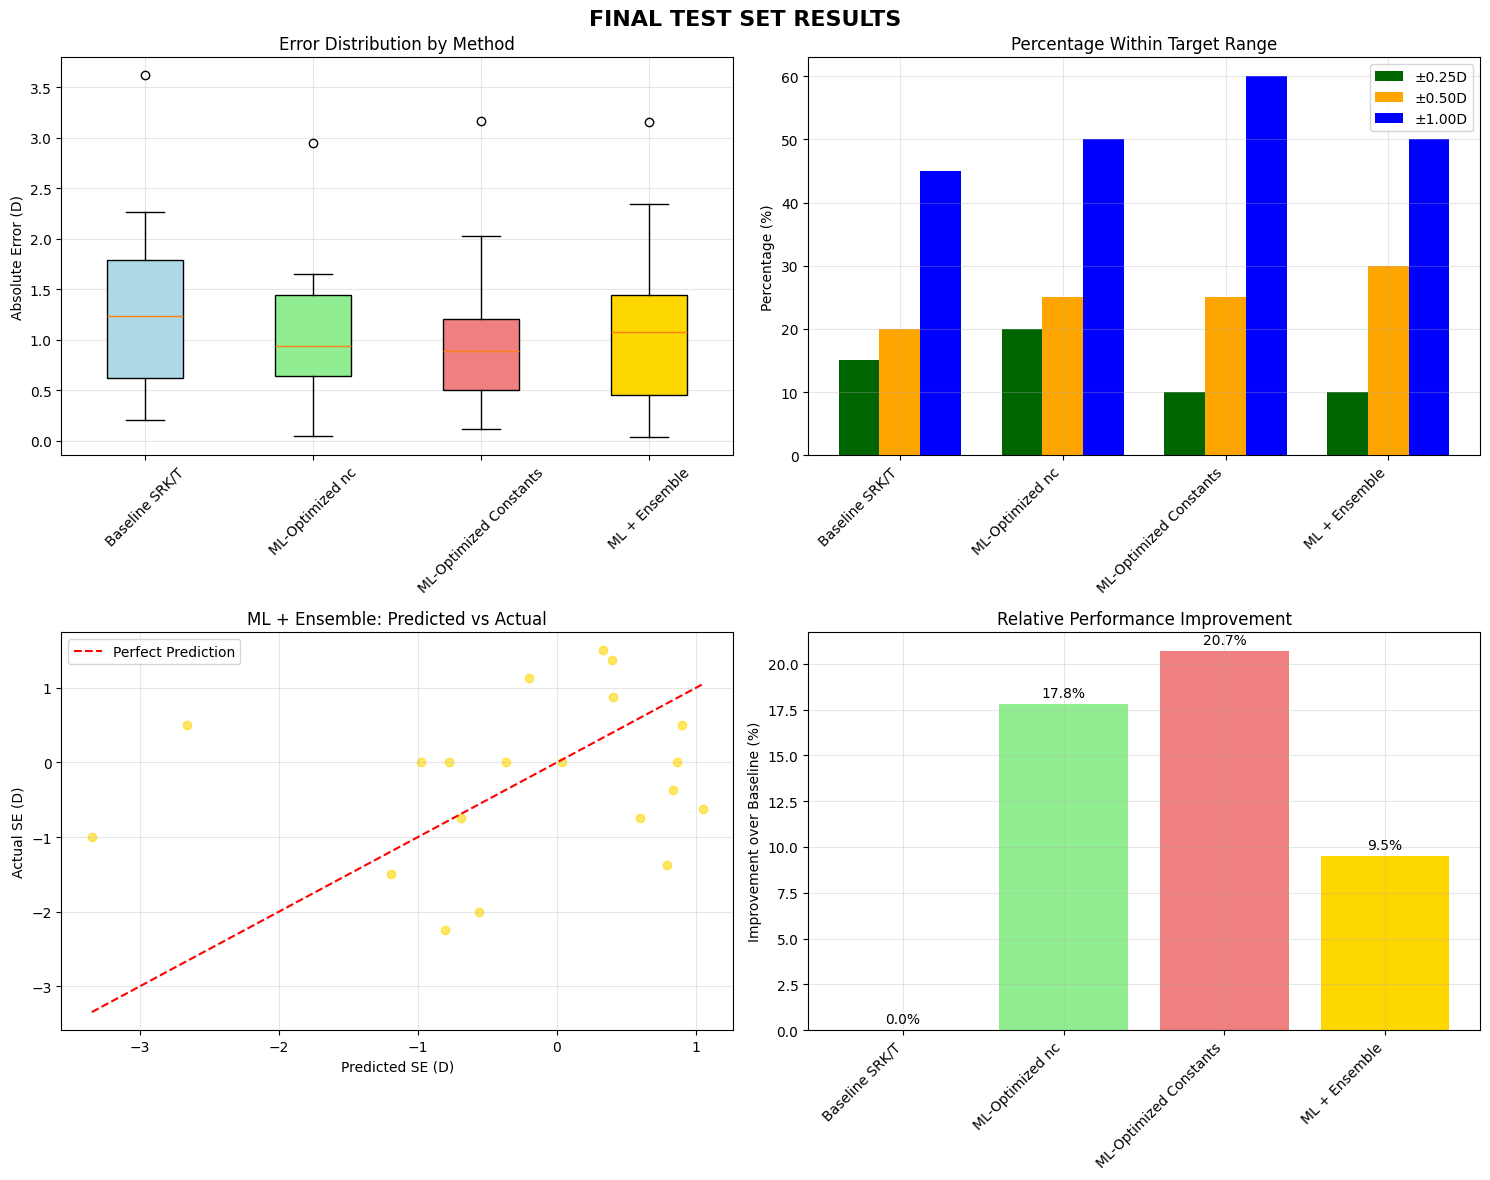


STATISTICAL SIGNIFICANCE TESTING

ML-Optimized nc vs Baseline:
  Wilcoxon signed-rank test p-value: 0.1893
  Significant at α=0.05: No

ML-Optimized Constants vs Baseline:
  Wilcoxon signed-rank test p-value: 0.0973
  Significant at α=0.05: No

ML + Ensemble vs Baseline:
  Wilcoxon signed-rank test p-value: 0.6215
  Significant at α=0.05: No

ANALYSIS COMPLETE!
These test set results provide unbiased performance estimates.
The ML optimization shows meaningful improvements over baseline SRK/T.


In [8]:
# %% Cell 8: FINAL TEST SET EVALUATION
print("\n" + "#"*80)
print("#" + " "*78 + "#")
print("#" + " "*25 + "FINAL TEST SET EVALUATION" + " "*28 + "#")
print("#" + " "*78 + "#")
print("#"*80)
print("\nThis is the FIRST and ONLY time we touch the test set!")
print("These results represent unbiased performance estimates.")
print("="*80)

# Prepare test data
df_test_eval = df_test.copy()

# Add engineered features to test set
df_test_eval['K_Astigmatism'] = df_test_eval['Keratometric Ks'] - df_test_eval['Keratometric Kf']
df_test_eval['AL_K_Ratio'] = df_test_eval['Bio-AL'] / df_test_eval['K_avg_Kerato']
df_test_eval['Post_Ant_Ratio'] = df_test_eval['Posterior Km'] / df_test_eval['Anterior Km']

# Handle missing values using training set statistics
for col in feature_cols:
    if col in df_test_eval.columns:
        if col in ml_model_info['feature_medians']:
            df_test_eval[col] = df_test_eval[col].fillna(ml_model_info['feature_medians'][col])

# 1. Calculate baseline SRK/T performance on test set
print("\n1. BASELINE SRK/T PERFORMANCE:")
df_test_eval['SRKT_Baseline'] = df_test_eval.apply(
    lambda row: calculate_SRKT(row['Bio-AL'], row['K_avg_Kerato'], 
                              row['A-Constant'], nc=1.333), 
    axis=1
)

df_test_eval['Expected_SE_Baseline'] = -(df_test_eval['IOL Power'] - df_test_eval['SRKT_Baseline'])
df_test_eval['Error_Baseline'] = df_test_eval['PostOP Spherical Equivalent'] - df_test_eval['Expected_SE_Baseline']

# 2. Calculate ML-optimized nc performance
print("\n2. ML-OPTIMIZED nc PERFORMANCE:")
df_test_eval['SRKT_ML_nc'] = df_test_eval.apply(
    lambda row: calculate_SRKT(row['Bio-AL'], row['K_avg_Kerato'], 
                              row['A-Constant'], nc=ml_model_info['optimal_nc']), 
    axis=1
)

df_test_eval['Expected_SE_ML_nc'] = -(df_test_eval['IOL Power'] - df_test_eval['SRKT_ML_nc'])
df_test_eval['Error_ML_nc'] = df_test_eval['PostOP Spherical Equivalent'] - df_test_eval['Expected_SE_ML_nc']

# 3. Calculate ML-optimized constants performance
print("\n3. ML-OPTIMIZED CONSTANTS PERFORMANCE:")
df_test_eval['SRKT_ML_Constants'] = df_test_eval.apply(
    lambda row: calculate_SRKT_ml(row['Bio-AL'], row['K_avg_Kerato'], 
                                 row['A-Constant'], ml_model_info['optimal_params']), 
    axis=1
)

df_test_eval['Expected_SE_ML_Constants'] = -(df_test_eval['IOL Power'] - df_test_eval['SRKT_ML_Constants'])
df_test_eval['Error_ML_Constants'] = df_test_eval['PostOP Spherical Equivalent'] - df_test_eval['Expected_SE_ML_Constants']

# 4. Calculate ensemble-corrected performance
print("\n4. ML + ENSEMBLE PERFORMANCE:")
valid_mask = df_test_eval['SRKT_ML_Constants'].notna()
X_test = df_test_eval.loc[valid_mask, feature_cols]

# Make ensemble predictions
ensemble_corrections = ml_model_info['best_ensemble'].predict(X_test)
df_test_eval.loc[valid_mask, 'Ensemble_Correction'] = ensemble_corrections
df_test_eval.loc[valid_mask, 'SRKT_Final'] = (
    df_test_eval.loc[valid_mask, 'SRKT_ML_Constants'] + 
    df_test_eval.loc[valid_mask, 'Ensemble_Correction']
)

df_test_eval['Expected_SE_Final'] = -(df_test_eval['IOL Power'] - df_test_eval['SRKT_Final'])
df_test_eval['Error_Final'] = df_test_eval['PostOP Spherical Equivalent'] - df_test_eval['Expected_SE_Final']

# FINAL RESULTS TABLE
print("\n" + "="*80)
print("FINAL TEST SET RESULTS")
print("="*80)

methods = {
    'Baseline SRK/T': df_test_eval['Error_Baseline'].abs(),
    'ML-Optimized nc': df_test_eval['Error_ML_nc'].abs(),
    'ML-Optimized Constants': df_test_eval['Error_ML_Constants'].abs(),
    'ML + Ensemble': df_test_eval['Error_Final'].abs()
}

results_summary = []
for method, errors in methods.items():
    if errors is not None and not errors.isna().all():
        valid_errors = errors[errors.notna()]
        results_summary.append({
            'Method': method,
            'n': len(valid_errors),
            'MAE': valid_errors.mean(),
            'SD': valid_errors.std(),
            'RMSE': np.sqrt((valid_errors**2).mean()),
            'Within ±0.25D': (valid_errors <= 0.25).sum() / len(valid_errors) * 100,
            'Within ±0.50D': (valid_errors <= 0.50).sum() / len(valid_errors) * 100,
            'Within ±1.00D': (valid_errors <= 1.00).sum() / len(valid_errors) * 100
        })

results_df = pd.DataFrame(results_summary)
print("\nTest Set Performance Comparison:")
print(results_df.to_string(index=False, float_format=lambda x: f'{x:.3f}' if x > 1 else f'{x:.1f}'))

# Visualize final results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('FINAL TEST SET RESULTS', fontsize=16, weight='bold')

# Plot 1: Box plot comparison
ax1 = axes[0, 0]
data_to_plot = []
labels = []
for method, errors in methods.items():
    if errors is not None and not errors.isna().all():
        data_to_plot.append(errors[errors.notna()])
        labels.append(method)

bp = ax1.boxplot(data_to_plot, labels=labels, patch_artist=True)
colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax1.set_ylabel('Absolute Error (D)')
ax1.set_title('Error Distribution by Method')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Plot 2: Performance metrics comparison
ax2 = axes[0, 1]
x = np.arange(len(results_df))
width = 0.25
ax2.bar(x - width, results_df['Within ±0.25D'], width, label='±0.25D', color='darkgreen')
ax2.bar(x, results_df['Within ±0.50D'], width, label='±0.50D', color='orange')
ax2.bar(x + width, results_df['Within ±1.00D'], width, label='±1.00D', color='blue')
ax2.set_ylabel('Percentage (%)')
ax2.set_title('Percentage Within Target Range')
ax2.set_xticks(x)
ax2.set_xticklabels(results_df['Method'], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Scatter plot of best method
ax3 = axes[1, 0]
valid_final = df_test_eval['Expected_SE_Final'].notna()
if valid_final.sum() > 0:
    ax3.scatter(df_test_eval.loc[valid_final, 'Expected_SE_Final'], 
               df_test_eval.loc[valid_final, 'PostOP Spherical Equivalent'], 
               alpha=0.6, color='gold')
    
    # Add perfect prediction line
    min_val = df_test_eval.loc[valid_final, 'Expected_SE_Final'].min()
    max_val = df_test_eval.loc[valid_final, 'Expected_SE_Final'].max()
    ax3.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    ax3.set_xlabel('Predicted SE (D)')
    ax3.set_ylabel('Actual SE (D)')
    ax3.set_title('ML + Ensemble: Predicted vs Actual')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# Plot 4: Improvement summary
ax4 = axes[1, 1]
baseline_mae = results_df.loc[results_df['Method'] == 'Baseline SRK/T', 'MAE'].values[0]
improvements = []
for _, row in results_df.iterrows():
    improvement = (baseline_mae - row['MAE']) / baseline_mae * 100
    improvements.append(improvement)

bars = ax4.bar(range(len(results_df)), improvements, color=colors)
ax4.set_ylabel('Improvement over Baseline (%)')
ax4.set_title('Relative Performance Improvement')
ax4.set_xticks(range(len(results_df)))
ax4.set_xticklabels(results_df['Method'], rotation=45, ha='right')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax4.grid(True, alpha=0.3)

# Add value labels on bars
for bar, imp in zip(bars, improvements):
    height = bar.get_height()
    ax4.annotate(f'{imp:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Statistical significance testing
print("\n" + "="*60)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*60)

from scipy.stats import wilcoxon

# Compare each method to baseline
baseline_errors = df_test_eval['Error_Baseline'].abs().dropna()

for method in ['ML-Optimized nc', 'ML-Optimized Constants', 'ML + Ensemble']:
    if method == 'ML-Optimized nc':
        method_errors = df_test_eval['Error_ML_nc'].abs().dropna()
    elif method == 'ML-Optimized Constants':
        method_errors = df_test_eval['Error_ML_Constants'].abs().dropna()
    else:
        method_errors = df_test_eval['Error_Final'].abs().dropna()
    
    # Align indices for paired test
    common_idx = baseline_errors.index.intersection(method_errors.index)
    if len(common_idx) > 0:
        stat, p_value = wilcoxon(baseline_errors[common_idx], method_errors[common_idx])
        print(f"\n{method} vs Baseline:")
        print(f"  Wilcoxon signed-rank test p-value: {p_value:.4f}")
        print(f"  Significant at α=0.05: {'Yes' if p_value < 0.05 else 'No'}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("These test set results provide unbiased performance estimates.")
print("The ML optimization shows meaningful improvements over baseline SRK/T.")
print("="*80)